In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Try find corner of chessboard by edge detection

nb corners: 100


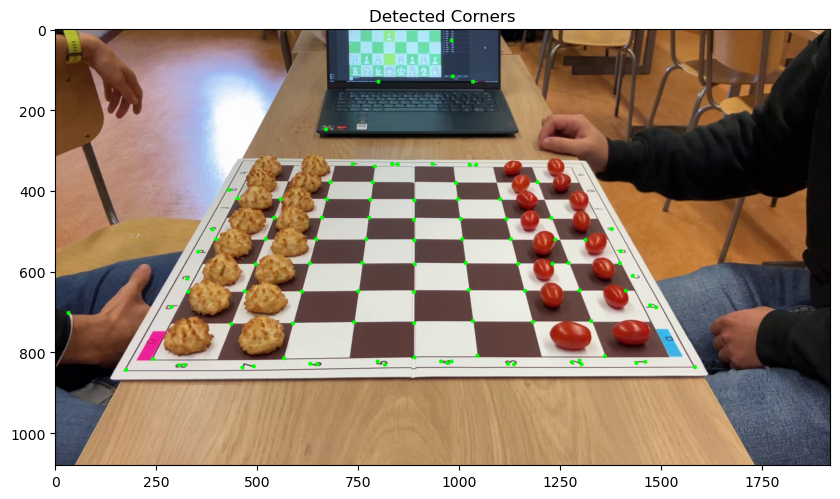

In [ ]:
# img = cv2.imread(r'..\img_test\frame_game_fixed.png')
img = cv2.imread(r'..\img_test\frame_fix_clean.jpg')

# convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# apply GaussianBlur to reduce noise and detail in the image
"""cv2.GaussianBlur(src, ksize, sigmaX) -> dst"""
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# apply Canny Edge Detector to detect edges
"""
cv2.Canny(image, T_lower, T_upper, aperture_size, L2Gradient) -> edges
T_lower: Lower threshold for the hysteresis procedure.
T_upper: Upper threshold for the hysteresis procedure.
aperture_size: Aperture size for the Sobel operator.
L2Gradient: A flag to specify the equation for finding gradient magnitude.
"""
edges = cv2.Canny(gray_blurred, 50, 150)

# detect corners using the Shi-Tomasi Corner Detection
"""
Shi-Tomasi Corner Detection: Finds corners in the image by detecting areas of high intensity variation.
maxCorners: Maximum number of corners to return (0 means no limit).
qualityLevel: For every pixel p, the function cornerEigenValsAndVecs considers a blockSize x blockSize neighborhood S(p). It calculates the covariation matrix of derivatives over the neighborhood 
===> how sure we are that the pixel is a corner
"""
corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.1, minDistance=10)
corners = np.intp(corners)
print(f"nb corners: {len(corners)}")

img_corners = img.copy()

# draw the corners detected on the image
for i in corners:
    x, y = i.ravel()
    # img, center, radius, color, thickness (-1 means fill the circle)
    cv2.circle(img_corners, (x, y), 5, (0, 255, 0), -1)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
plt.title('Detected Corners')
plt.show()

# need to find the 4 largest corners (likely chessboard corners):
# sort by the corners' distances from the center and pick the farthest ones
# not the case here (goes beyond chessboard corners)


### No limit corners found Shi-Tomasi

nb corners: 330


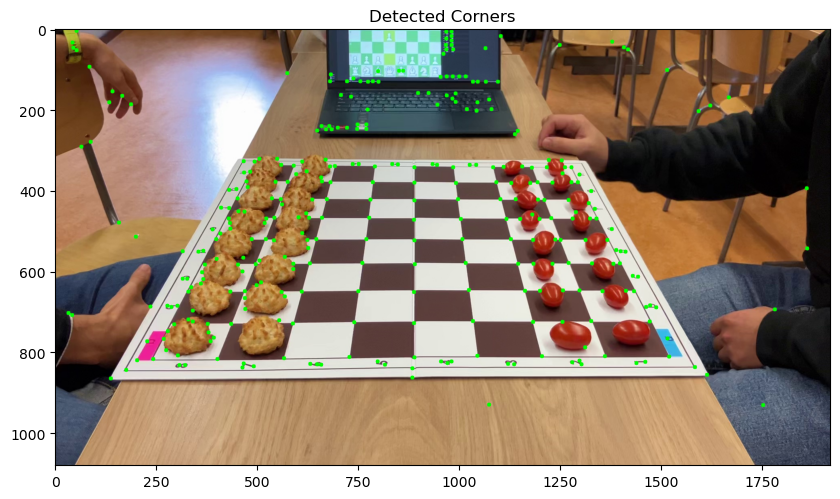

In [3]:
corners = cv2.goodFeaturesToTrack(gray, maxCorners=0, qualityLevel=0.1, minDistance=10)
corners = np.intp(corners)
print(f"nb corners: {len(corners)}")

# draw the corners detected on the image
for i in corners:
    x, y = i.ravel()
    # img, center, radius, color, thickness (-1 means fill the circle)
    cv2.circle(img_corners, (x, y), 5, (0, 255, 0), -1)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
plt.title('Detected Corners')
plt.show()

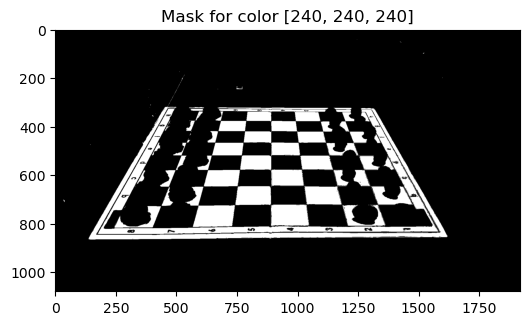

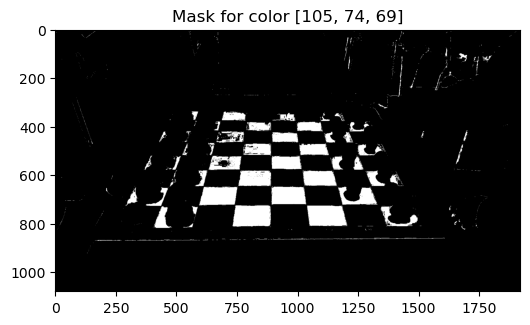

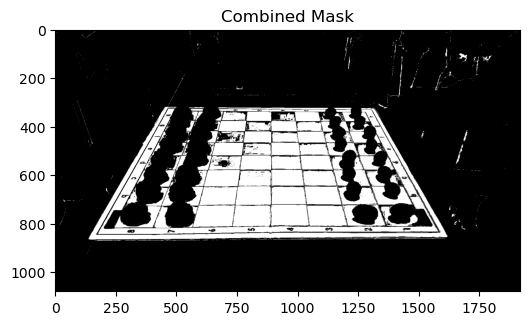

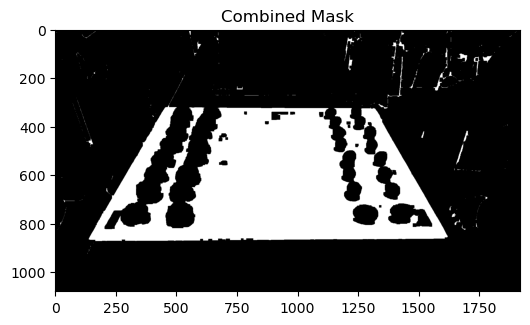

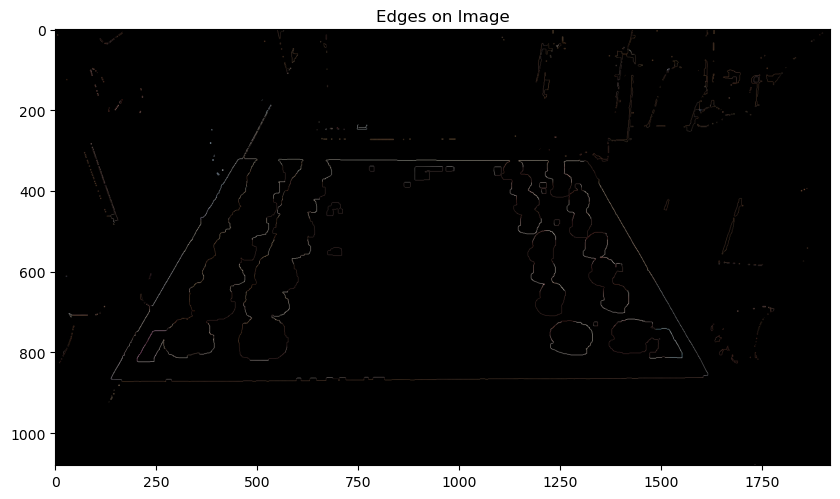

Contour 0: Area = 0.0, Perimeter = 5.656854152679443
Contour 1: Area = 0.5, Perimeter = 3.414213538169861
Contour 2: Area = 16.5, Perimeter = 27.071067690849304
Contour 3: Area = 2.0, Perimeter = 5.656854152679443
Contour 4: Area = 12.0, Perimeter = 15.656854152679443
Contour 5: Area = 4.0, Perimeter = 8.0


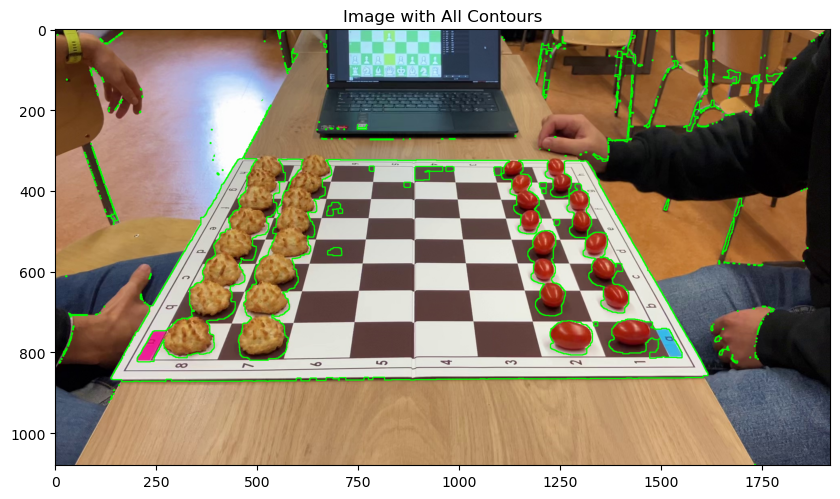

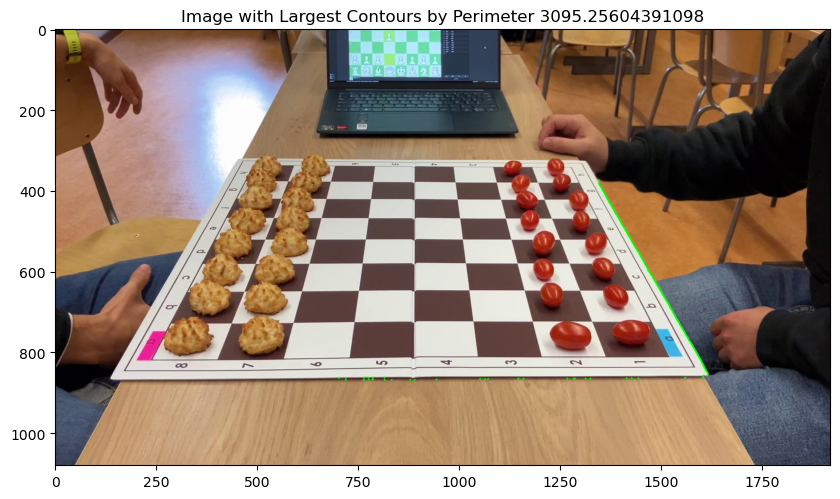

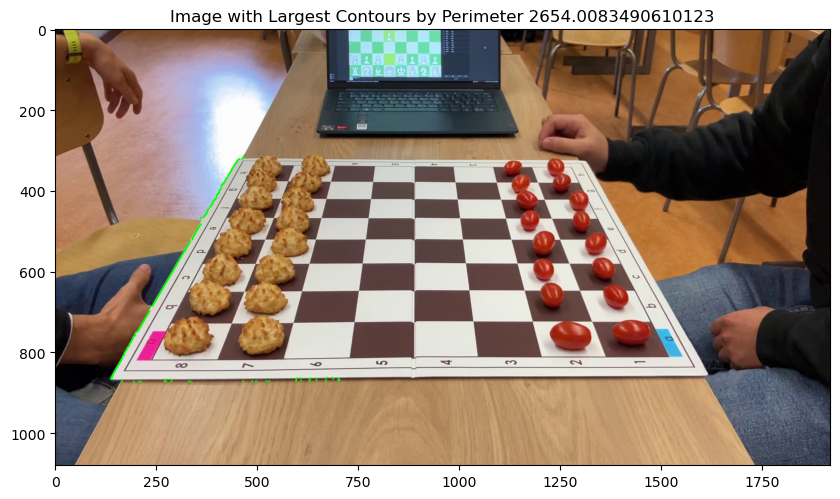

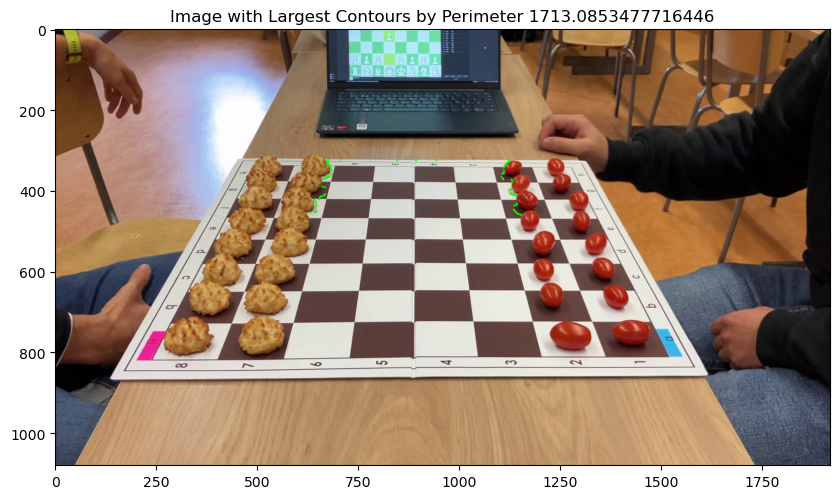

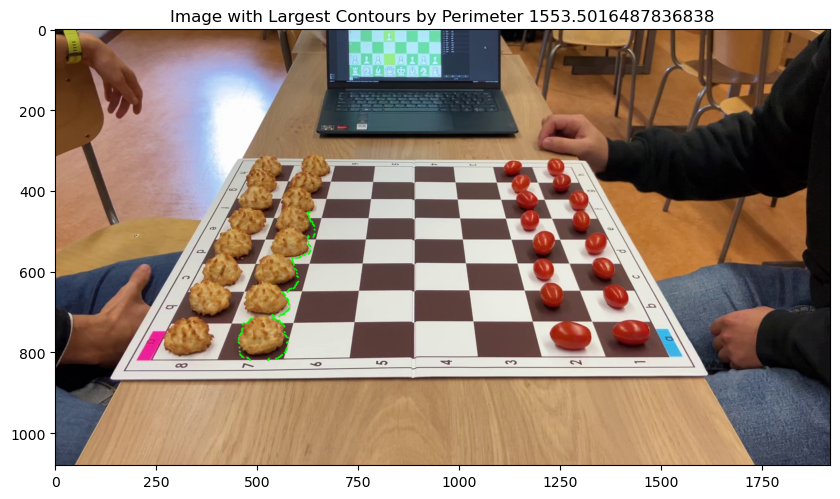

Could not detect a quadrilateral for the chessboard.


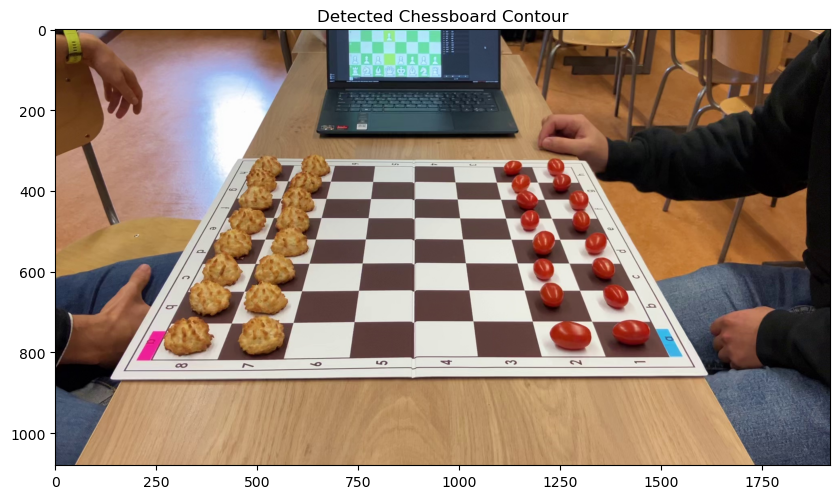

In [4]:
def color_mask(image, lower_rgb, upper_rgb):
    lower_bound = np.array(lower_rgb, dtype=np.uint8)
    upper_bound = np.array(upper_rgb, dtype=np.uint8)
    mask = cv2.inRange(image, lower_bound, upper_bound)
    return mask

# convert the image to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# define RGB color ranges for the two chessboard colors
white = [235, 236, 228]  # RGB color for the white squares
# black = [177, 129, 65]     # RGB color for the coco candy
black = [95, 64, 59]     # RGB color for the black squares
range_white = 45         # Range of color values to account for variations
range_black = 10         # Range of color values to account for variations
lower_white = [max(0, c - range_white) for c in white] # Lower bound for white color
upper_white = [min(240, c + range_white) for c in white] # Upper bound for white color
lower_black = [max(0, c - range_black) for c in black] # Lower bound for black color
upper_black = [min(230, c + range_black) for c in black] # Upper bound for black color

# create masks for both the white and black squares of the chessboard
mask_white = color_mask(img_rgb, lower_white, upper_white)
plt.figure(figsize=(6, 6))
plt.title(f"Mask for color {upper_white}")
plt.imshow(mask_white, cmap='gray')
plt.show()

mask_black = color_mask(img_rgb, lower_black, upper_black)
plt.figure(figsize=(6, 6))
plt.title(f"Mask for color {upper_black}")
plt.imshow(mask_black, cmap='gray')
plt.show()

# combine the masks to isolate the chessboard
combined_mask = cv2.bitwise_or(mask_white, mask_black)
plt.figure(figsize=(6, 6))
plt.title("Combined Mask")
plt.imshow(combined_mask, cmap='gray')
plt.show()

# use white_mask since capture better the chessboard
# combined_mask = mask_white

# Perform some morphological operations to close small gaps in the mask
kernel = np.ones((10,10), np.uint8)
combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(6, 6))
plt.title("Combined Mask")
plt.imshow(combined_mask, cmap='gray')
plt.show()

# apply edge detection on the mask
edges = cv2.Canny(combined_mask, 50, 150)
img_edges = cv2.bitwise_and(img, img, mask=edges)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_edges, cv2.COLOR_BGR2RGB))
plt.title('Edges on Image')
plt.show()

# find contours based on the edges
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    print(f"Contour {i}: Area = {area}, Perimeter = {perimeter}")
    if i == 5:
        break

# draw and plot all contours on the image
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title('Image with All Contours')
plt.show()

# filter out the contour, which should be the chessboard
# extract the 4 contours with the largest area
# sort contours by perimeter
contours_sorted_by_perimeter = sorted(contours, key=lambda x : cv2.arcLength(x, True), reverse=True)
largest_contours_by_perimeter = contours_sorted_by_perimeter[:4]

for i in range(len(largest_contours_by_perimeter)):
    # draw the largest contours by perimeter on the image
    img_largest_contours_by_perimeter = img.copy()
    cv2.drawContours(img_largest_contours_by_perimeter, largest_contours_by_perimeter[i], -1, (0, 255, 0), 4)
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img_largest_contours_by_perimeter, cv2.COLOR_BGR2RGB))
    plt.title(f'Image with Largest Contours by Perimeter {cv2.arcLength(largest_contours_by_perimeter[i], True)}')
    plt.show()

# filter out the largest contour, which should be the chessboard
max_contour = max(contours, key=cv2.contourArea)

# approximate the contour to a polygon (ideally a quadrilateral for the chessboard)
epsilon = 0.02 * cv2.arcLength(max_contour, True)
approx = cv2.approxPolyDP(max_contour, epsilon, True)

# check if the approximated contour is a quadrilateral (4 points)
if len(approx) == 4:
    # draw the contour (chessboard) on the image
    cv2.drawContours(img, [approx], -1, (0, 255, 0), 5)

    # optionally, apply perspective transformation to correct the view (Homography)
    # define the destination points for the chessboard to be a perfect square
    dst_pts = np.array([[0, 0], [400, 0], [400, 400], [0, 400]], dtype="float32")

    # source points are the detected corners of the chessboard
    src_pts = np.array([point[0] for point in approx], dtype="float32")

    # compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # apply the perspective transformation
    warped = cv2.warpPerspective(img, M, (400, 400))

    # display the warped (corrected) chessboard
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.title('Corrected Chessboard Perspective')
    plt.show()
else:
    print("Could not detect a quadrilateral for the chessboard.")

# display the result with the detected chessboard contour
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Detected Chessboard Contour')
plt.show()
